# Creating synthetic attrition data with the Python Faker library for attrition predictive modelling

Composition of the dataset for predictive purposes:
- unique employee numbers to serve as index column
- department (HR, Finance, Marketing, Sales, IT, Customer Service, Legal, Project Management)
- province (in Canada)
- hierarchy level (individual contributor, manager/director, senior leadership)
- tenure with the current company (in years)
- previous experience (in years)
- hiring source (agency, direct, employee referral)
- promoted or not yet promoted
- resigned or stayed
- gender (male, female, non-binary)
- ethnicity (caucasian, african descent, indigenous, bi-racial, hispanic, pacific islander, middle eastern, asian)

In [1]:
# importing data creation libraries
from faker import Faker
from faker.providers import DynamicProvider
from random import choices
import random

# data manipulation & analysis libraries
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis

# data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# creating a Canadian Faker instance
fake= Faker(locale= 'en_CA')

# creating the list of hierarchy levels with their weights
hierarchy_pool = ["Individual contributor","Manager/Director","Senior Leadership"]
h_wts=[0.79,0.16,0.05]

# instancing the dynamic provider
hierarchy_level = DynamicProvider(provider_name="level",
                                  elements=choices(hierarchy_pool,
                                                   weights=h_wts,
                                    k=len(hierarchy_pool)))

# adding the new provider to the Faker instance
fake.add_provider(hierarchy_level)

# creating the list of genders with their weights
gender_pool = ["male","female","non-binary"]
g_wts=[0.49,0.49,0.02]

# instancing the dynamic provider
gender = DynamicProvider(provider_name="gender",
                                  elements=choices(gender_pool,
                                                   weights=g_wts,
                                    k=len(gender_pool)))

# adding the new provider to the Faker instance
fake.add_provider(gender)

# creating the list of ethnicities with their weights
ethnicity_pool = ["caucasian", "african descent", "indigenous", "bi-racial",\
                  "hispanic", "pacific islander", "middle eastern", "asian"]
e_wts=[0.61,0.04,0.06,0.03,0.03,0.01,0.02,0.2]

# instancing the dynamic provider
ethnicity = DynamicProvider(provider_name="ethnicity",
                                  elements=choices(ethnicity_pool,weights=e_wts,
                                    k=len(ethnicity_pool)))

# adding the new provider to the Faker instance
fake.add_provider(ethnicity)

# creating the list of hiring sources with their weights
source_pool = ["agency", "direct", "referral"]
s_wts=[0.2, 0.5, 0.3]

# instancing the dynamic provider
source = DynamicProvider(provider_name="source",
                                  elements=choices(source_pool,
                                                   weights=s_wts,
                                    k=len(source_pool)))

# adding the new provider to the Faker instance
fake.add_provider(source)

In [3]:
# creating a function to generate employee records
def create_employees(num_employees):
    employee_list = []
    for i in range(1, num_employees):
        employee = {}
        employee['ee#'] = 10000000+i
        employee['age'] = random.randint(25,70)
        employee['department'] = fake.random_element(
            elements=("HR","Finance","Marketing","Sales",
                      "IT","Customer Service","Legal",
                      "Project Management"))
        employee['province'] = fake.province()
        employee['level'] = fake.level()
        employee['tenure'] = round(random.uniform(0,30),1)
        employee['previous_xp'] = round(random.uniform(0,30),1)  

# ensuring realism with total work experience < 40 years
        total_xp = employee['tenure'] + employee['previous_xp']
        if total_xp >40:
            excess_xp = total_xp - 40
            if employee['tenure'] > employee['previous_xp']:
                employee['tenure'] = max(employee['tenure'] \
                                         - excess_xp, 0)
            else:
                employee['previous_xp'] = max(employee['previous_xp'] \
                                              - excess_xp, 0)

# ensuring realism between age & total experience
        total_xp = employee['tenure'] + employee['previous_xp']
        max_xp = employee['age'] - 25
        if total_xp > max_xp:
            excess_xp = total_xp - max_xp
            if employee['tenure'] > employee['previous_xp']:
                employee['tenure'] = max(employee['tenure'] \
                                         - excess_xp, 0)
            else:
                employee['previous_xp'] = max(employee['previous_xp'] \
                                              - excess_xp, 0)
        employee['total_xp'] = employee['tenure'] \
                                + employee['previous_xp']
        employee['gender'] = fake.gender()
        employee['ethnicity'] = fake.ethnicity()
        employee['hire_source'] = fake.source()
        employee['promotion'] = fake.random_element(
            elements= ("promoted", "not_promoted"))
        employee_list.append(employee)
    return pd.DataFrame(employee_list)

In [4]:
# creating a dataframe to hold the output of the function
# and visualize it to check for correct output
attrition = create_employees(2000000)
print(attrition.shape)
print(attrition.columns)
attrition.sample(n=5)

(1999999, 12)
Index(['ee#', 'age', 'department', 'province', 'level', 'tenure',
       'previous_xp', 'total_xp', 'gender', 'ethnicity', 'hire_source',
       'promotion'],
      dtype='object')


,ee#,age,department,province,level,tenure,previous_xp,total_xp,gender,ethnicity,hire_source,promotion
1955998,11955999,40,Customer Service,Northwest Territories,Individual contributor,3.2,11.8,15.0,female,hispanic,direct,promoted
1555514,11555515,64,Marketing,Yukon Territory,Individual contributor,14.8,24.2,39.0,female,caucasian,direct,promoted
1142571,11142572,70,Finance,Nova Scotia,Individual contributor,1.4,10.3,11.7,female,caucasian,direct,promoted
594355,10594356,44,Legal,Nunavut,Manager/Director,8.5,10.5,19.0,female,asian,direct,not_promoted
1562679,11562680,41,HR,Alberta,Manager/Director,0.7,4.0,4.7,female,caucasian,direct,not_promoted


## Exploratory data analysis

In [5]:
# categorical data profiling with formatted outputs
def category_profiling(df, cat_columns):
    print(df.nunique())
    print("---")
    print(df.dtypes)
    print("---")
    for col in cat_columns:
        percentages = df[col].value_counts(normalize=True).mul(100).round(1).astype(str)+'%'
        print(percentages)
        print("---")

cat_columns = ['department', 'province', 'level', \
               'gender', 'ethnicity', 'hire_source', 'promotion']

category_profiling(attrition, cat_columns)

ee#            1999999
age                 46
department           8
province            13
level                2
tenure            1338
previous_xp       1341
total_xp           995
gender               1
ethnicity            3
hire_source          2
promotion            2
dtype: int64
---
ee#              int64
age              int64
department      object
province        object
level           object
tenure         float64
previous_xp    float64
total_xp       float64
gender          object
ethnicity       object
hire_source     object
promotion       object
dtype: object
---
department
Marketing             12.6%
Legal                 12.5%
Customer Service      12.5%
Project Management    12.5%
Finance               12.5%
Sales                 12.5%
HR                    12.5%
IT                    12.5%
Name: proportion, dtype: object
---
province
Nunavut                      7.7%
Prince Edward Island         7.7%
British Columbia             7.7%
Nova Scotia                  7.

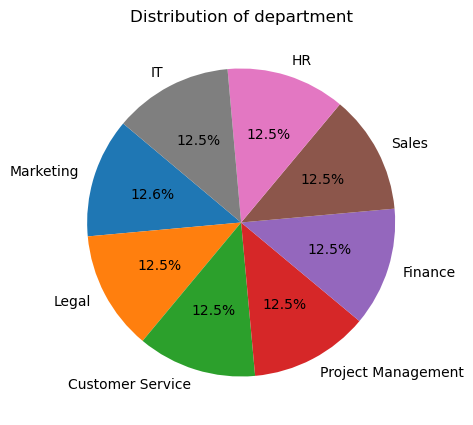

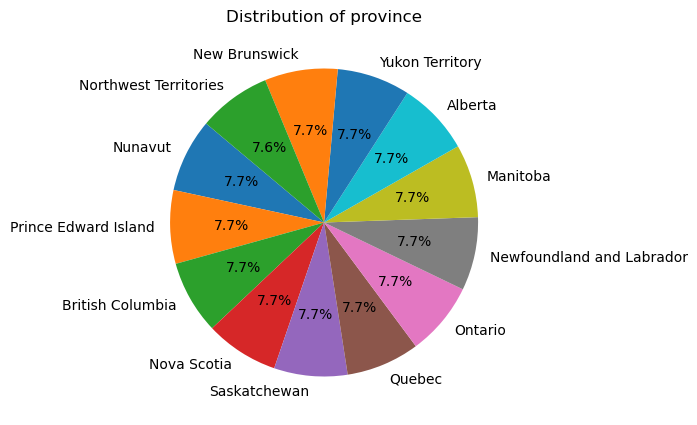

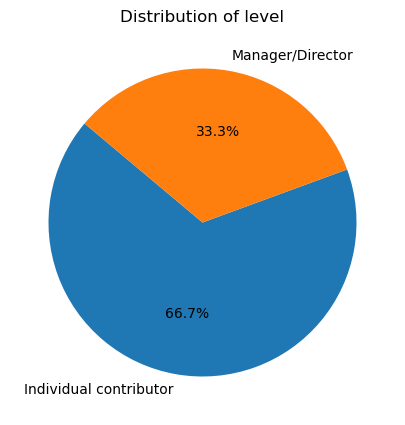

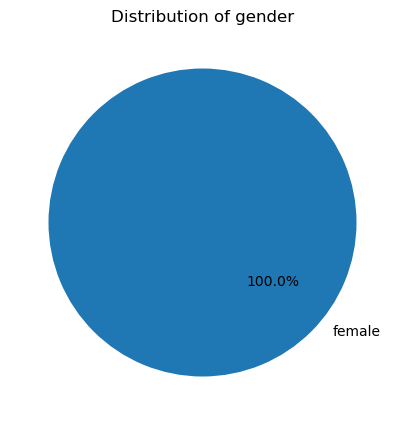

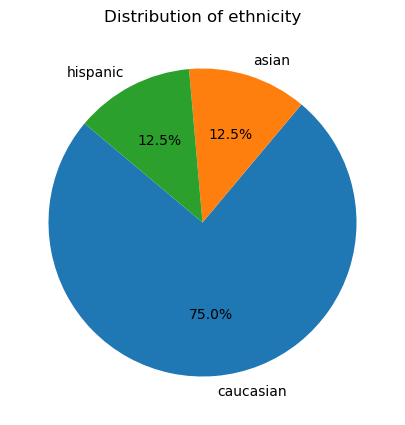

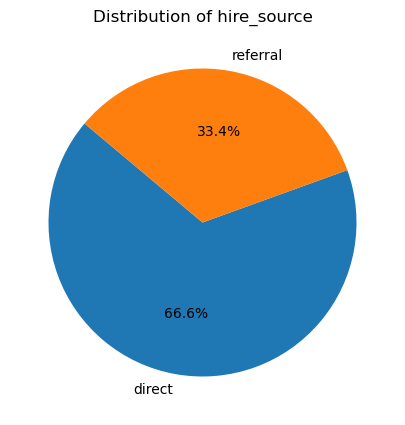

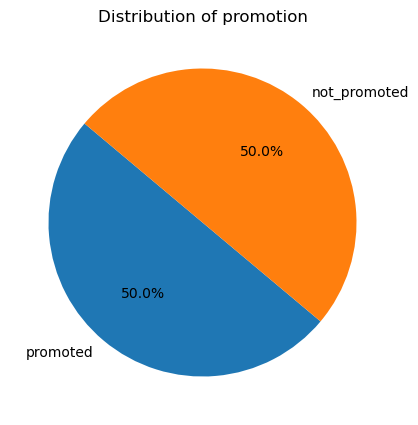

In [6]:
# plotting categorical columns' distributions
def cat_distribution_plots(data, cat_columns):
    for col in cat_columns:
        graph_data= data[col].value_counts()

        plt.figure(figsize= (10,5))
        plt.pie(graph_data.values,
                labels= graph_data.index,
                autopct= '%1.1f%%',
                startangle= 140)
        plt.title(f'Distribution of {col}')
        plt.show()

cat_distribution_plots(attrition, cat_columns)

In [7]:
# numerical data profiling with formatted outputs
def numerical_profiling(df,num_columns):
    for col in num_columns:
        column = df[col]
        stats = {
            "min": column.min(),
            "max": column.max(),
            "avg": column.mean().round(0),
            "stdev": column.std(),
            "1st quartile": np.percentile(a= column, q= 25),
            "2nd quartile": np.percentile(a= column, q= 50),
            "3rd quartile": np.percentile(a= column, q= 75),
            "skew": skew(column, axis=0, bias=True),
            "kurtosis": kurtosis(column, axis=0, 
                                 fisher=True, bias=True)}
        
        print(f"Statistics for {col.capitalize()}:")
        for stat, value in stats.items():
            print(f"{stat}: {value}")
        print("---")

num_columns = ['tenure', 'previous_xp', 'total_xp', 'age']

numerical_profiling(attrition, num_columns)

Statistics for Tenure:
min: 0.0
max: 30.0
avg: 10.0
stdev: 7.357856017839379
1st quartile: 3.3
2nd quartile: 9.2
3rd quartile: 15.6
skew: 0.3721839549233525
kurtosis: -0.7921146824587351
---
Statistics for Previous_xp:
min: 0.0
max: 30.0
avg: 10.0
stdev: 7.358604480674443
1st quartile: 3.3
2nd quartile: 9.2
3rd quartile: 15.6
skew: 0.3747876131470003
kurtosis: -0.7887982027075724
---
Statistics for Total_xp:
min: 0.0
max: 40.0
avg: 20.0
stdev: 9.597445159124094
1st quartile: 12.5
2nd quartile: 18.6
3rd quartile: 26.6
skew: 0.2994634655335349
kurtosis: -0.6724066436931913
---
Statistics for Age:
min: 25
max: 70
avg: 47.0
stdev: 13.275227635614716
1st quartile: 36.0
2nd quartile: 48.0
3rd quartile: 59.0
skew: -5.324976357069094e-05
kurtosis: -1.2005034424412522
---


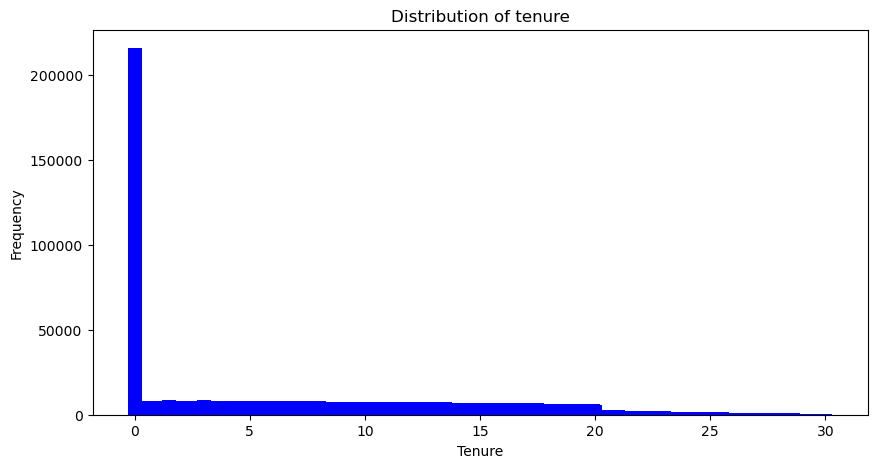

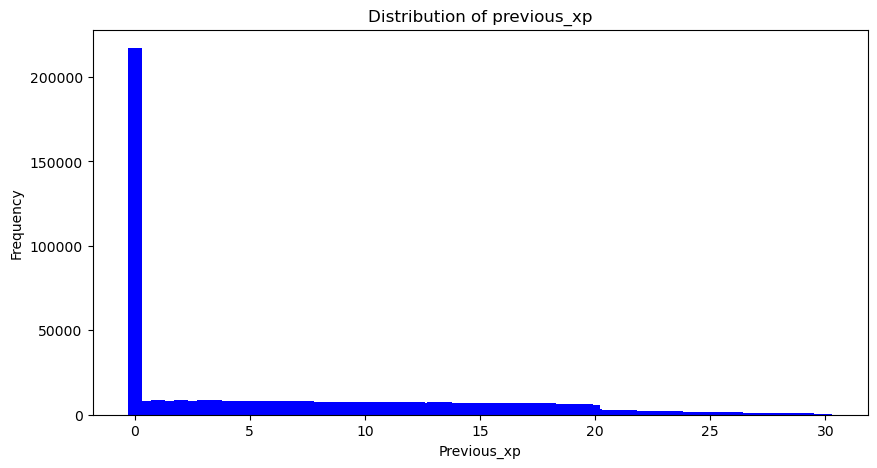

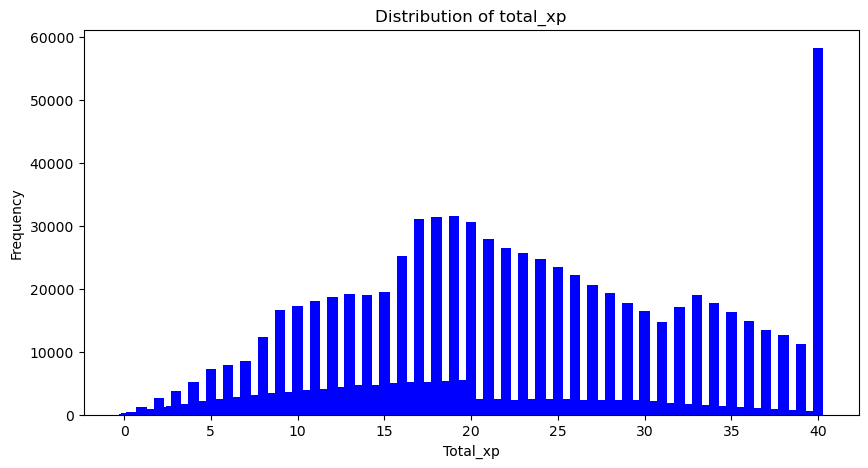

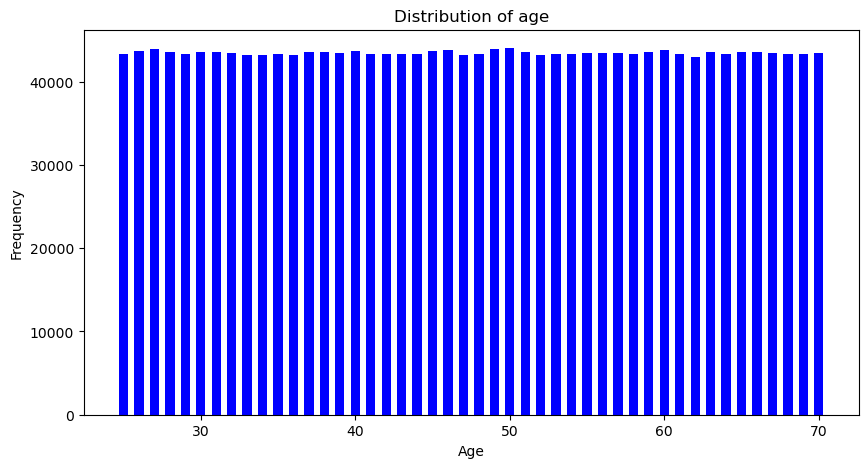

In [8]:
# plotting numerical columns' distributions
def num_distribution_plots(data, num_columns):
    for col in num_columns:
        graph_data = data[col].value_counts().sort_index()

        plt.figure(figsize= (10,5))
        plt.bar(graph_data.index,
                graph_data.values,
                color= 'blue',
                width= 0.6)
        plt.xlabel(col.capitalize())
        plt.ylabel('Frequency')
        plt.title(f'Distribution of {col}')
        plt.show()

num_distribution_plots(attrition, num_columns)

## Exporting the dataframe as a .csv file

In [9]:
# export the dataframe to .csv file
attrition.to_csv('attrition_df.csv',index=False)